# INF-0616 - Projeto 3: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- a229999@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/469](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=469)

Instituto de Computação - Unicamp 2022

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [2]:
np.random.seed(12049)

plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [3]:
d = pd.read_csv('./customer-issues.csv')
display(d.head())

,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [4]:
d['product'].unique()

array(['Credit reporting', 'Consumer Loan', 'Debt collection', 'Mortgage',
       'Credit card', 'Other financial service',
       'Bank account or service', 'Student loan', 'Money transfers',
       'Payday loan', 'Prepaid card', 'Virtual currency',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card or prepaid card', 'Checking or savings account',
       'Payday loan, title loan, or personal loan',
       'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service'], dtype=object)

In [5]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [6]:
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [7]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]
    
    (sns
     .barplot([l[:40] for l in labels], counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)
    
    return labels, counts

/home/nelson/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


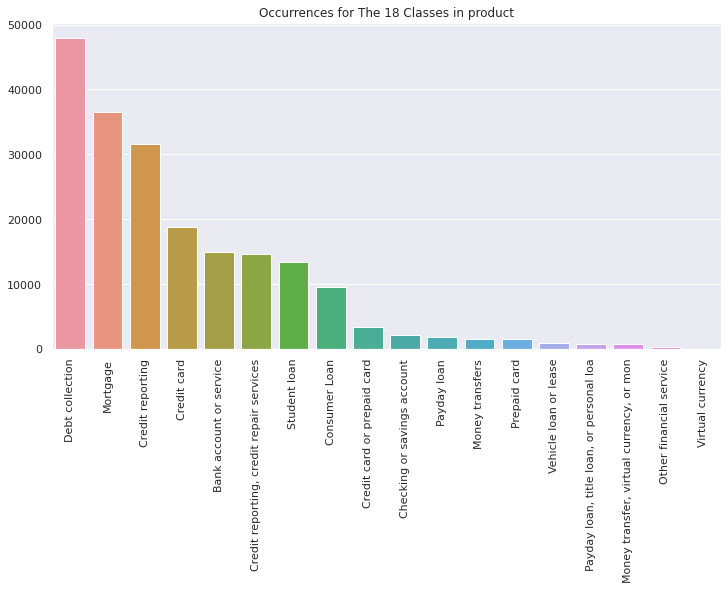

In [8]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [9]:
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [14]:
# Linear Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold

rs = 12049

cv = KFold(n_splits=5, shuffle=True, random_state=rs)

logisticModel = LogisticRegression()

param_grid = [    
    {'C' : np.logspace(-3, 2, 6),
     'max_iter': [100, 500, 1000, 2000]}
]

lr_grid = GridSearchCV(estimator = logisticModel, 
                       param_grid = param_grid, 
                       cv = cv, 
                       verbose=10)


lr_grid.fit(X=x_train, y=ye_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START C=0.001, max_iter=100......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 1/24] END .......C=0.001, max_iter=100;, score=0.832 total time=   4.8s
[CV 2/5; 1/24] START C=0.001, max_iter=100......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 1/24] END .......C=0.001, max_iter=100;, score=0.831 total time=   4.1s
[CV 3/5; 1/24] START C=0.001, max_iter=100......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 1/24] END .......C=0.001, max_iter=100;, score=0.831 total time=   4.3s
[CV 4/5; 1/24] START C=0.001, max_iter=100......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 1/24] END .......C=0.001, max_iter=100;, score=0.831 total time=   4.2s
[CV 5/5; 1/24] START C=0.001, max_iter=100......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 1/24] END .......C=0.001, max_iter=100;, score=0.828 total time=   4.3s
[CV 1/5; 2/24] START C=0.001, max_iter=500......................................
[CV 1/5; 2/24] END .......C=0.001, max_iter=500;, score=0.832 total time=   5.5s
[CV 2/5; 2/24] START C=0.001, max_iter=500......................................
[CV 2/5; 2/24] END .......C=0.001, max_iter=500;, score=0.831 total time=   5.6s
[CV 3/5; 2/24] START C=0.001, max_iter=500......................................
[CV 3/5; 2/24] END .......C=0.001, max_iter=500;, score=0.831 total time=   5.2s
[CV 4/5; 2/24] START C=0.001, max_iter=500......................................
[CV 4/5; 2/24] END .......C=0.001, max_iter=500;, score=0.831 total time=   5.3s
[CV 5/5; 2/24] START C=0.001, max_iter=500......................................
[CV 5/5; 2/24] END .......C=0.001, max_iter=500;, score=0.828 total time=   5.1s
[CV 1/5; 3/24] START C=0.001, max_iter=1000.....................................
[CV 1/5; 3/24] END ......C=0

/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 5/24] END ........C=0.01, max_iter=100;, score=0.832 total time=   4.5s
[CV 2/5; 5/24] START C=0.01, max_iter=100.......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 5/24] END ........C=0.01, max_iter=100;, score=0.831 total time=   4.4s
[CV 3/5; 5/24] START C=0.01, max_iter=100.......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 5/24] END ........C=0.01, max_iter=100;, score=0.830 total time=   4.7s
[CV 4/5; 5/24] START C=0.01, max_iter=100.......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 5/24] END ........C=0.01, max_iter=100;, score=0.833 total time=   4.5s
[CV 5/5; 5/24] START C=0.01, max_iter=100.......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 5/24] END ........C=0.01, max_iter=100;, score=0.830 total time=   5.3s
[CV 1/5; 6/24] START C=0.01, max_iter=500.......................................
[CV 1/5; 6/24] END ........C=0.01, max_iter=500;, score=0.832 total time=   7.3s
[CV 2/5; 6/24] START C=0.01, max_iter=500.......................................
[CV 2/5; 6/24] END ........C=0.01, max_iter=500;, score=0.831 total time=   7.2s
[CV 3/5; 6/24] START C=0.01, max_iter=500.......................................
[CV 3/5; 6/24] END ........C=0.01, max_iter=500;, score=0.831 total time=   6.8s
[CV 4/5; 6/24] START C=0.01, max_iter=500.......................................
[CV 4/5; 6/24] END ........C=0.01, max_iter=500;, score=0.832 total time=   7.2s
[CV 5/5; 6/24] START C=0.01, max_iter=500.......................................
[CV 5/5; 6/24] END ........C=0.01, max_iter=500;, score=0.830 total time=   7.1s
[CV 1/5; 7/24] START C=0.01, max_iter=1000......................................
[CV 1/5; 7/24] END .......C=

/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 9/24] END .........C=0.1, max_iter=100;, score=0.831 total time=   4.2s
[CV 2/5; 9/24] START C=0.1, max_iter=100........................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 9/24] END .........C=0.1, max_iter=100;, score=0.830 total time=   4.4s
[CV 3/5; 9/24] START C=0.1, max_iter=100........................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 9/24] END .........C=0.1, max_iter=100;, score=0.829 total time=   4.2s
[CV 4/5; 9/24] START C=0.1, max_iter=100........................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 9/24] END .........C=0.1, max_iter=100;, score=0.832 total time=   4.4s
[CV 5/5; 9/24] START C=0.1, max_iter=100........................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 9/24] END .........C=0.1, max_iter=100;, score=0.830 total time=   4.4s
[CV 1/5; 10/24] START C=0.1, max_iter=500.......................................
[CV 1/5; 10/24] END ........C=0.1, max_iter=500;, score=0.831 total time=  11.6s
[CV 2/5; 10/24] START C=0.1, max_iter=500.......................................
[CV 2/5; 10/24] END ........C=0.1, max_iter=500;, score=0.830 total time=  11.8s
[CV 3/5; 10/24] START C=0.1, max_iter=500.......................................
[CV 3/5; 10/24] END ........C=0.1, max_iter=500;, score=0.829 total time=  11.3s
[CV 4/5; 10/24] START C=0.1, max_iter=500.......................................
[CV 4/5; 10/24] END ........C=0.1, max_iter=500;, score=0.832 total time=  11.1s
[CV 5/5; 10/24] START C=0.1, max_iter=500.......................................
[CV 5/5; 10/24] END ........C=0.1, max_iter=500;, score=0.830 total time=  10.8s
[CV 1/5; 11/24] START C=0.1, max_iter=1000......................................
[CV 1/5; 11/24] END .......C

/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 13/24] END ........C=1.0, max_iter=100;, score=0.831 total time=   4.7s
[CV 2/5; 13/24] START C=1.0, max_iter=100.......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 13/24] END ........C=1.0, max_iter=100;, score=0.830 total time=   4.5s
[CV 3/5; 13/24] START C=1.0, max_iter=100.......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 13/24] END ........C=1.0, max_iter=100;, score=0.830 total time=   4.6s
[CV 4/5; 13/24] START C=1.0, max_iter=100.......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 13/24] END ........C=1.0, max_iter=100;, score=0.832 total time=   4.7s
[CV 5/5; 13/24] START C=1.0, max_iter=100.......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 13/24] END ........C=1.0, max_iter=100;, score=0.830 total time=   4.6s
[CV 1/5; 14/24] START C=1.0, max_iter=500.......................................
[CV 1/5; 14/24] END ........C=1.0, max_iter=500;, score=0.831 total time=  20.0s
[CV 2/5; 14/24] START C=1.0, max_iter=500.......................................
[CV 2/5; 14/24] END ........C=1.0, max_iter=500;, score=0.830 total time=  18.5s
[CV 3/5; 14/24] START C=1.0, max_iter=500.......................................
[CV 3/5; 14/24] END ........C=1.0, max_iter=500;, score=0.829 total time=  20.6s
[CV 4/5; 14/24] START C=1.0, max_iter=500.......................................
[CV 4/5; 14/24] END ........C=1.0, max_iter=500;, score=0.832 total time=  20.7s
[CV 5/5; 14/24] START C=1.0, max_iter=500.......................................
[CV 5/5; 14/24] END ........C=1.0, max_iter=500;, score=0.830 total time=  21.2s
[CV 1/5; 15/24] START C=1.0, max_iter=1000......................................
[CV 1/5; 15/24] END .......C

/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 17/24] END .......C=10.0, max_iter=100;, score=0.831 total time=   4.4s
[CV 2/5; 17/24] START C=10.0, max_iter=100......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 17/24] END .......C=10.0, max_iter=100;, score=0.830 total time=   4.5s
[CV 3/5; 17/24] START C=10.0, max_iter=100......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 17/24] END .......C=10.0, max_iter=100;, score=0.830 total time=   5.0s
[CV 4/5; 17/24] START C=10.0, max_iter=100......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 17/24] END .......C=10.0, max_iter=100;, score=0.832 total time=   4.7s
[CV 5/5; 17/24] START C=10.0, max_iter=100......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 17/24] END .......C=10.0, max_iter=100;, score=0.830 total time=   4.7s
[CV 1/5; 18/24] START C=10.0, max_iter=500......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 18/24] END .......C=10.0, max_iter=500;, score=0.831 total time=  22.7s
[CV 2/5; 18/24] START C=10.0, max_iter=500......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 18/24] END .......C=10.0, max_iter=500;, score=0.830 total time=  22.1s
[CV 3/5; 18/24] START C=10.0, max_iter=500......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 18/24] END .......C=10.0, max_iter=500;, score=0.829 total time=  22.7s
[CV 4/5; 18/24] START C=10.0, max_iter=500......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 18/24] END .......C=10.0, max_iter=500;, score=0.832 total time=  21.3s
[CV 5/5; 18/24] START C=10.0, max_iter=500......................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 18/24] END .......C=10.0, max_iter=500;, score=0.830 total time=  21.1s
[CV 1/5; 19/24] START C=10.0, max_iter=1000.....................................
[CV 1/5; 19/24] END ......C=10.0, max_iter=1000;, score=0.831 total time=  29.6s
[CV 2/5; 19/24] START C=10.0, max_iter=1000.....................................
[CV 2/5; 19/24] END ......C=10.0, max_iter=1000;, score=0.830 total time=  26.9s
[CV 3/5; 19/24] START C=10.0, max_iter=1000.....................................
[CV 3/5; 19/24] END ......C=10.0, max_iter=1000;, score=0.829 total time=  24.0s
[CV 4/5; 19/24] START C=10.0, max_iter=1000.....................................
[CV 4/5; 19/24] END ......C=10.0, max_iter=1000;, score=0.832 total time=  27.7s
[CV 5/5; 19/24] START C=10.0, max_iter=1000.....................................
[CV 5/5; 19/24] END ......C=10.0, max_iter=1000;, score=0.830 total time=  27.4s
[CV 1/5; 20/24] START C=10.0, max_iter=2000.....................................
[CV 1/5; 20/24] END ......C=

/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 21/24] END ......C=100.0, max_iter=100;, score=0.831 total time=   4.6s
[CV 2/5; 21/24] START C=100.0, max_iter=100.....................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 21/24] END ......C=100.0, max_iter=100;, score=0.830 total time=   4.6s
[CV 3/5; 21/24] START C=100.0, max_iter=100.....................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 21/24] END ......C=100.0, max_iter=100;, score=0.830 total time=   4.6s
[CV 4/5; 21/24] START C=100.0, max_iter=100.....................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 21/24] END ......C=100.0, max_iter=100;, score=0.832 total time=   4.2s
[CV 5/5; 21/24] START C=100.0, max_iter=100.....................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 21/24] END ......C=100.0, max_iter=100;, score=0.830 total time=   4.3s
[CV 1/5; 22/24] START C=100.0, max_iter=500.....................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 22/24] END ......C=100.0, max_iter=500;, score=0.831 total time=  22.3s
[CV 2/5; 22/24] START C=100.0, max_iter=500.....................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 22/24] END ......C=100.0, max_iter=500;, score=0.830 total time=  23.7s
[CV 3/5; 22/24] START C=100.0, max_iter=500.....................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 22/24] END ......C=100.0, max_iter=500;, score=0.829 total time=  23.0s
[CV 4/5; 22/24] START C=100.0, max_iter=500.....................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 22/24] END ......C=100.0, max_iter=500;, score=0.832 total time=  23.1s
[CV 5/5; 22/24] START C=100.0, max_iter=500.....................................


/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 22/24] END ......C=100.0, max_iter=500;, score=0.830 total time=  22.9s
[CV 1/5; 23/24] START C=100.0, max_iter=1000....................................
[CV 1/5; 23/24] END .....C=100.0, max_iter=1000;, score=0.831 total time=  41.3s
[CV 2/5; 23/24] START C=100.0, max_iter=1000....................................
[CV 2/5; 23/24] END .....C=100.0, max_iter=1000;, score=0.830 total time=  35.8s
[CV 3/5; 23/24] START C=100.0, max_iter=1000....................................
[CV 3/5; 23/24] END .....C=100.0, max_iter=1000;, score=0.829 total time=  31.9s
[CV 4/5; 23/24] START C=100.0, max_iter=1000....................................
[CV 4/5; 23/24] END .....C=100.0, max_iter=1000;, score=0.832 total time=  31.3s
[CV 5/5; 23/24] START C=100.0, max_iter=1000....................................
[CV 5/5; 23/24] END .....C=100.0, max_iter=1000;, score=0.830 total time=  40.7s
[CV 1/5; 24/24] START C=100.0, max_iter=2000....................................
[CV 1/5; 24/24] END .....C=1

/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=KFold(n_splits=5, random_state=12049, shuffle=True),
             estimator=LogisticRegression(),
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'max_iter': [100, 500, 1000, 2000]}],
             verbose=10)

In [15]:
print(lr_grid.best_estimator_)
g = lr_grid.best_estimator_

LogisticRegression(C=0.01)


Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [16]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))
    
    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.distplot(probabilities[y.ravel() == i][:, i],
                     hist=False,
                     label=labels[i])

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

In [17]:
g.fit(x_train, ye_train)

/home/nelson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01)

Accuracy: 0.758
Accuracy (balanced): 0.736


/home/nelson/.local/lib/python3.10/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/nelson/.local/lib/python3.10/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/nelson/.local/lib/python3.10/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

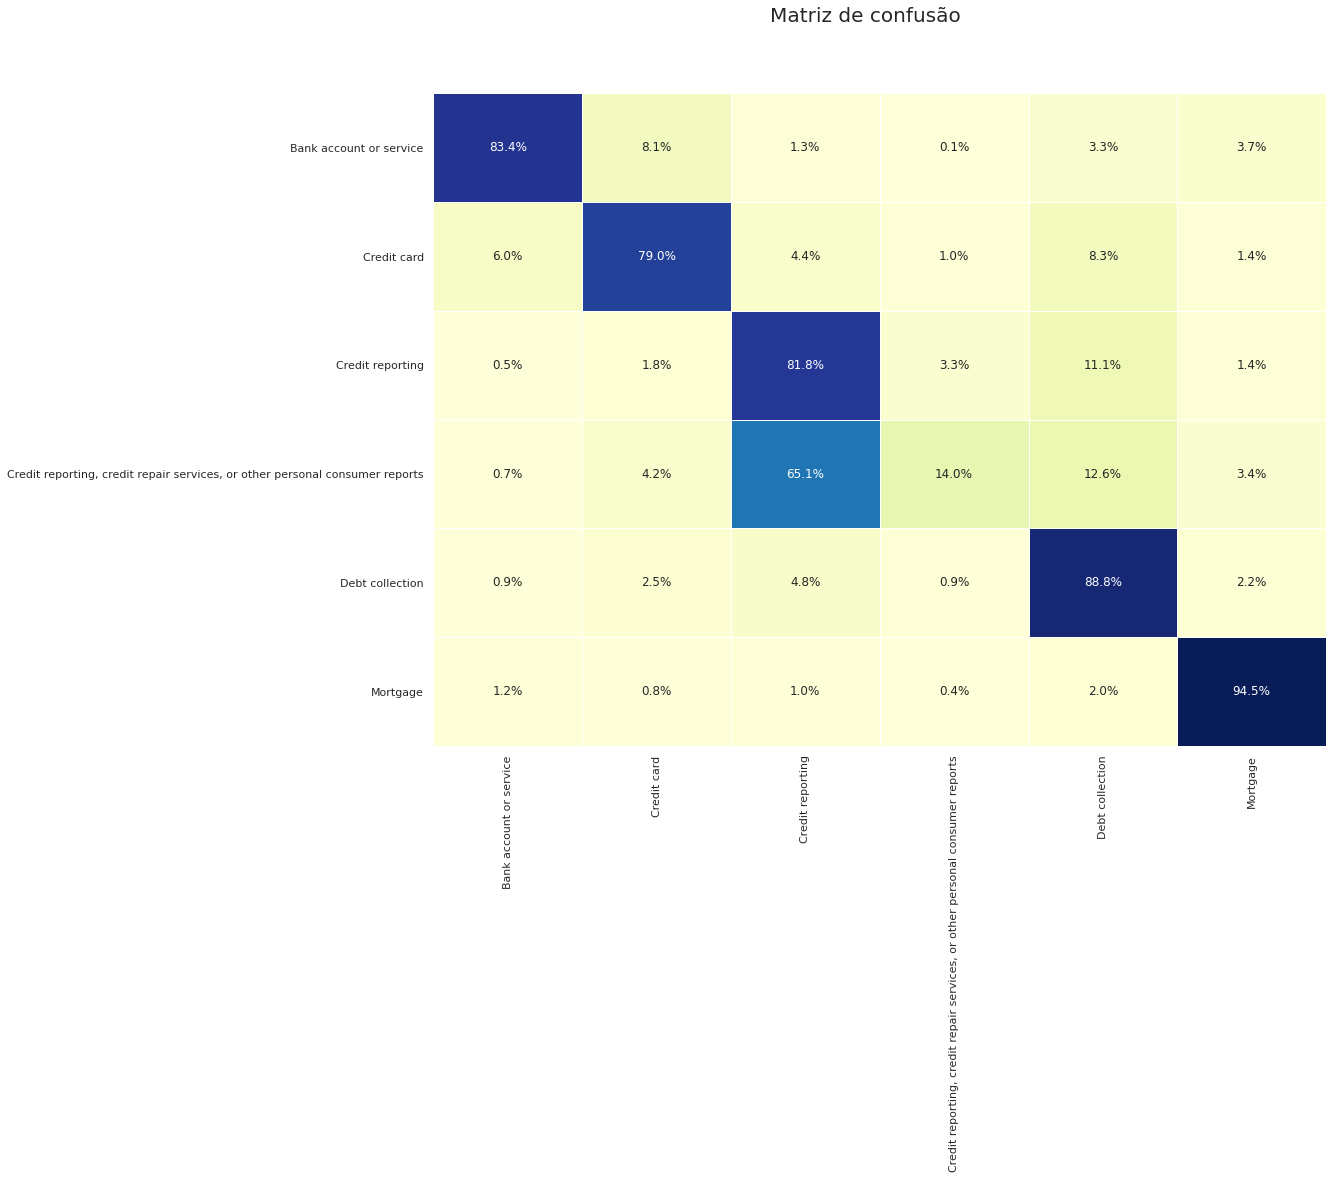

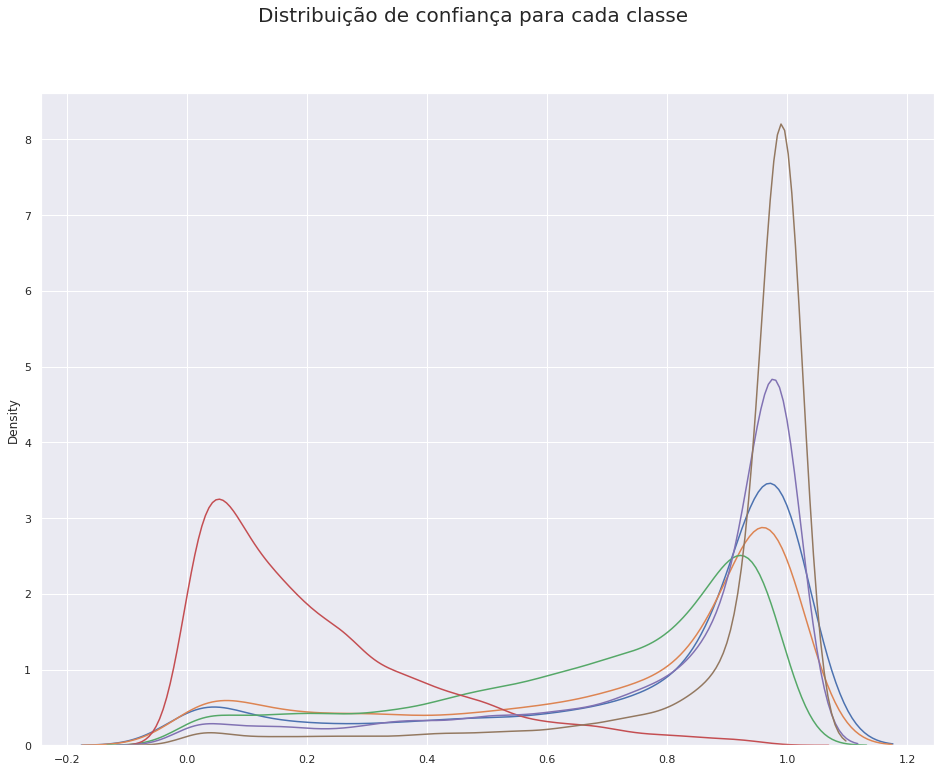

In [18]:
evaluate(ye_test, g.predict(x_test), g.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

Percebemos que, das seis classes, apenas a "Credit reporting, credit repair services, or other personal consumer reports" apresenta um resultado ruim, sendo que $65\%$ dos elementos desta classe
foram preditos como pertencendo a outra classe. Isto se deve basicamente devido a características das classes em questão.

A "Credit reporting, credit repair services, or other personal consumer reports" deveria estar contida na outra, o que leva o modelo a ficar confuso e por isso classificar de maneira ruim este em específico
 
 Além disto, notamos que para vários valores de $C$ e $max_iter$, o método de otimização **LBFGS** não convergiu, muito provavelmente devido ao problema de dependência entre as classes analisadas. 

----------
----------

## Redes Neurais
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

In [11]:
epochs = 20
batch_size = 128
input_shape = [features]

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [12]:
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, InputLayer
from keras.utils import np_utils
from keras import optimizers
import tensorflow as tf
from keras import callbacks



y_ohe_train = np_utils.to_categorical(ye_train, num_classes=6)
y_ohe_test = np_utils.to_categorical(ye_test, num_classes=6)

2022-10-14 23:58:05.937985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 23:58:06.064742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 23:58:06.064763: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-14 23:58:06.096235: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-14 23:58:06.960636: W tensorflow/stream_executor/platform/de

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema. 

In [13]:
model = Sequential([
    InputLayer((1024,)),
    Dense(512, activation="relu"),
    Dense(512, activation="relu"),
    Dense(6, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 790,534
Trainable params: 790,534
Non-trainable params: 0
_________________________________________________________________


2022-10-14 23:58:07.554598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-14 23:58:07.554621: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-14 23:58:07.554638: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nelson-pc): /proc/driver/nvidia/version does not exist
2022-10-14 23:58:07.554872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
sgd = optimizers.SGD(learning_rate=0.01) #lr = learning rate
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy'])

### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [15]:
# Separamos trainVal em treino e validação.
(X_train, X_val, y_train, y_val) = train_test_split(x_train, y_ohe_train,
                                                    test_size=0.3)

In [16]:
# Ordenando os conjuntos

X_train.sort_indices()
X_val.sort_indices()
x_test.sort_indices()

In [17]:
device = '/cpu:0'  # ou '/gpu:0'

with tf.device(device):
    model.fit(X_train, y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_val, y_val),
              verbose=1,
              callbacks=[
                  callbacks.TerminateOnNaN(),
                  callbacks.ModelCheckpoint('weights.h5',
                                            save_best_only=True,
                                            verbose=1),
              ])

Epoch 1/20


2022-10-14 23:58:08.295263: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50616512 exceeds 10% of free system memory.
/home/nelson/.local/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


629/630 [============================>.] - ETA: 0s - loss: 0.9533 - accuracy: 0.6708
Epoch 1: val_loss improved from inf to 0.67170, saving model to weights.h5
630/630 [==============================] - 14s 21ms/step - loss: 0.9528 - accuracy: 0.6710 - val_loss: 0.6717 - val_accuracy: 0.7763
Epoch 2/20
627/630 [============================>.] - ETA: 0s - loss: 0.5979 - accuracy: 0.7995
Epoch 2: val_loss improved from 0.67170 to 0.59298, saving model to weights.h5
630/630 [==============================] - 12s 20ms/step - loss: 0.5981 - accuracy: 0.7995 - val_loss: 0.5930 - val_accuracy: 0.8026
Epoch 3/20
628/630 [============================>.] - ETA: 0s - loss: 0.5300 - accuracy: 0.8221
Epoch 3: val_loss improved from 0.59298 to 0.56358, saving model to weights.h5
630/630 [==============================] - 13s 20ms/step - loss: 0.5297 - accuracy: 0.8221 - val_loss: 0.5636 - val_accuracy: 0.8113
Epoch 4/20
629/630 [============================>.] - ETA: 0s - loss: 0.4895 - accuracy: 0.

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

In [18]:
model.load_weights('weights.h5')

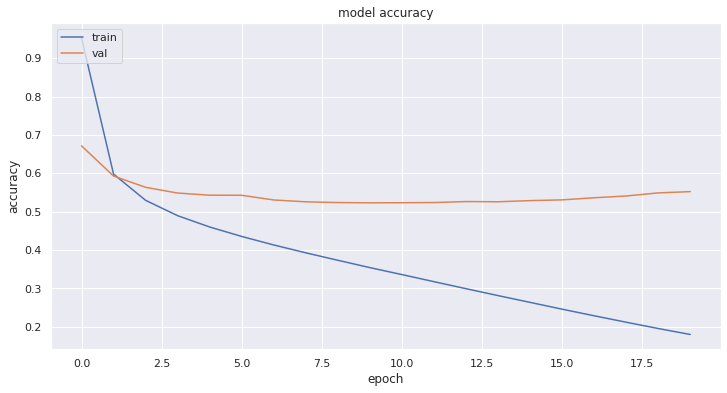

In [19]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Notamos que a partir da epoch $10$ a função loss de treino começou a cair enquanto a val_loss passou a aumentar, levando a um comportamento de *overfitting*

### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

In [46]:
probs = model.predict(x_test)
predicted_classes = np.argmax(probs, axis=-1)

1543/1543 [==============================] - 5s 3ms/step


Accuracy: 0.743
Accuracy (balanced): 0.719


/home/nelson/.local/lib/python3.10/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/nelson/.local/lib/python3.10/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/nelson/.local/lib/python3.10/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

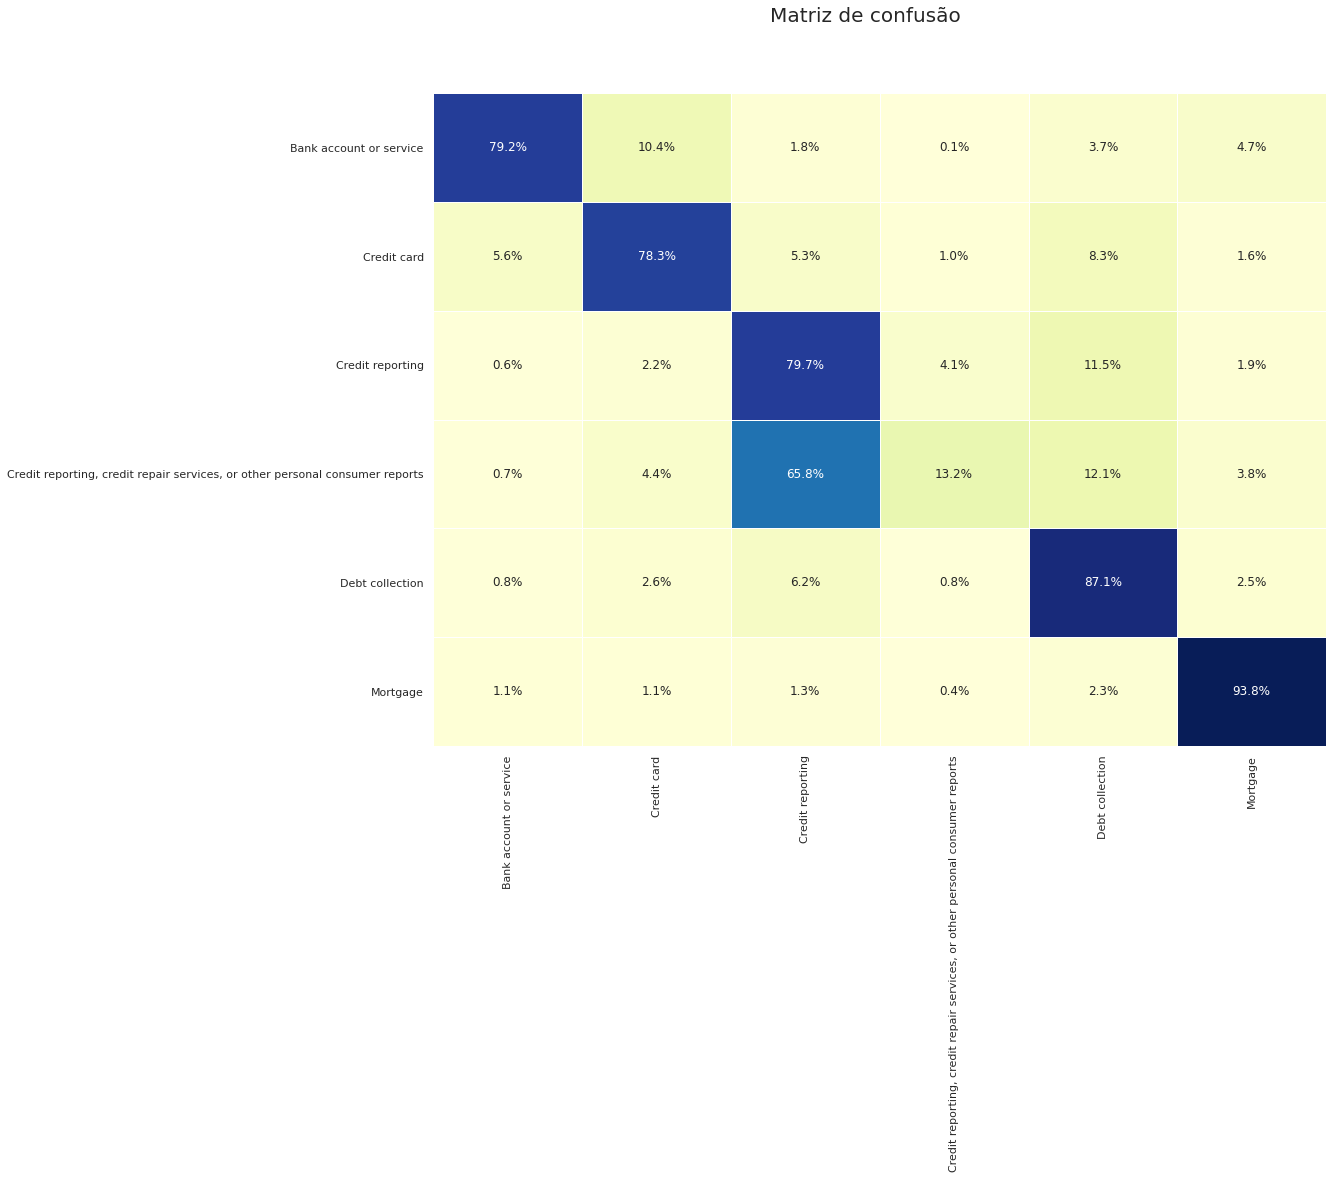

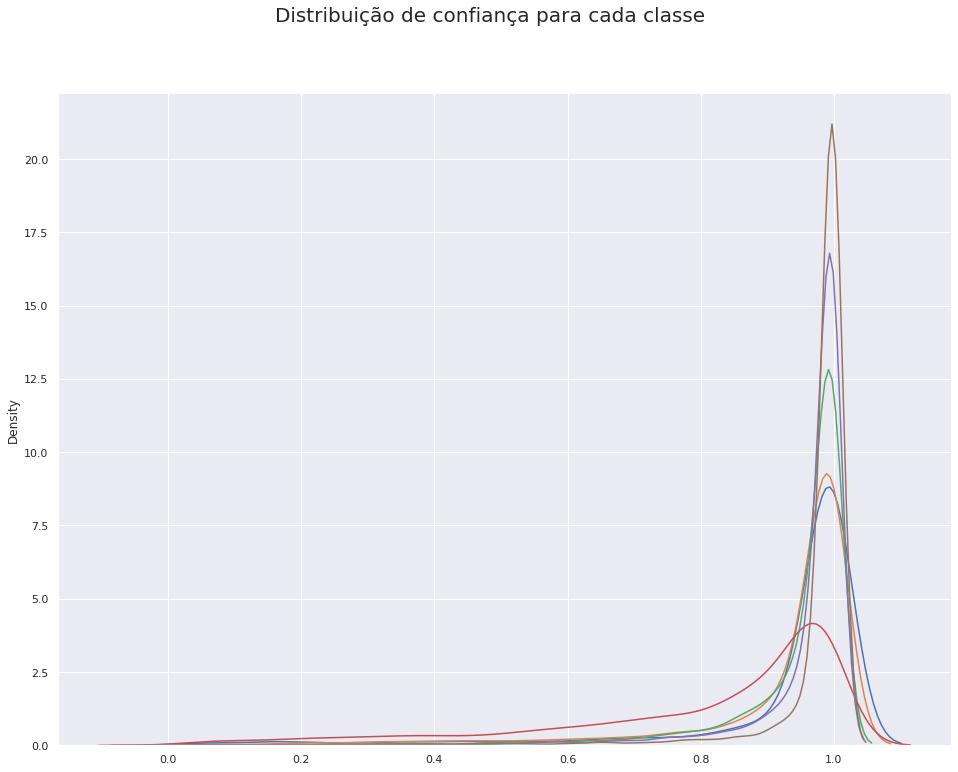

In [47]:
evaluate(ye_test, predicted_classes, probs, labels=label_enc.classes_)

--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [49]:
model_complex = Sequential([
    InputLayer((1024,)),
    Dense(960, activation="relu"),
    Dense(480, activation="relu"),
    Dense(240, activation="relu"),
    Dense(120, activation="relu"),
    Dense(60, activation="relu"),
    Dense(6, activation="sigmoid")
])

model_complex.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 960)               984000    
                                                                 
 dense_13 (Dense)            (None, 480)               461280    
                                                                 
 dense_14 (Dense)            (None, 240)               115440    
                                                                 
 dense_15 (Dense)            (None, 120)               28920     
                                                                 
 dense_16 (Dense)            (None, 60)                7260      
                                                                 
 dense_17 (Dense)            (None, 6)                 366       
                                                                 
Total params: 1,597,266
Trainable params: 1,597,266
No

In [50]:
sgd = optimizers.SGD(learning_rate=0.01) #lr = learning rate
model_complex.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [55]:
with tf.device(device):
    model_complex.fit(X_train, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(X_val, y_val),
                      verbose=1,
                      callbacks=[
                          callbacks.TerminateOnNaN(),
                          callbacks.ModelCheckpoint('weights.h5',
                                                    save_best_only=True,
                                                    verbose=1),
              ])

Epoch 1/15


/home/nelson/.local/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_3/dense_12/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_3/dense_12/embedding_lookup_sparse/Reshape:0", shape=(None, 960), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_3/dense_12/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


629/630 [============================>.] - ETA: 0s - loss: 1.0304 - accuracy: 0.6302
Epoch 1: val_loss improved from inf to 0.65480, saving model to weights.h5
630/630 [==============================] - 24s 37ms/step - loss: 1.0301 - accuracy: 0.6303 - val_loss: 0.6548 - val_accuracy: 0.7754
Epoch 2/15
629/630 [============================>.] - ETA: 0s - loss: 0.5864 - accuracy: 0.8000
Epoch 2: val_loss improved from 0.65480 to 0.58378, saving model to weights.h5
630/630 [==============================] - 22s 35ms/step - loss: 0.5862 - accuracy: 0.8000 - val_loss: 0.5838 - val_accuracy: 0.7998
Epoch 3/15
630/630 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.8262
Epoch 3: val_loss improved from 0.58378 to 0.55634, saving model to weights.h5
630/630 [==============================] - 22s 34ms/step - loss: 0.5065 - accuracy: 0.8262 - val_loss: 0.5563 - val_accuracy: 0.8084
Epoch 4/15
629/630 [============================>.] - ETA: 0s - loss: 0.4558 - accuracy: 0.

In [56]:
model_complex.load_weights('weights.h5')

In [57]:
probs = model_complex.predict(x_test)
predicted_classes = np.argmax(probs, axis=-1)

1543/1543 [==============================] - 8s 5ms/step


Accuracy: 0.736
Accuracy (balanced): 0.709


/home/nelson/.local/lib/python3.10/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/nelson/.local/lib/python3.10/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/nelson/.local/lib/python3.10/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

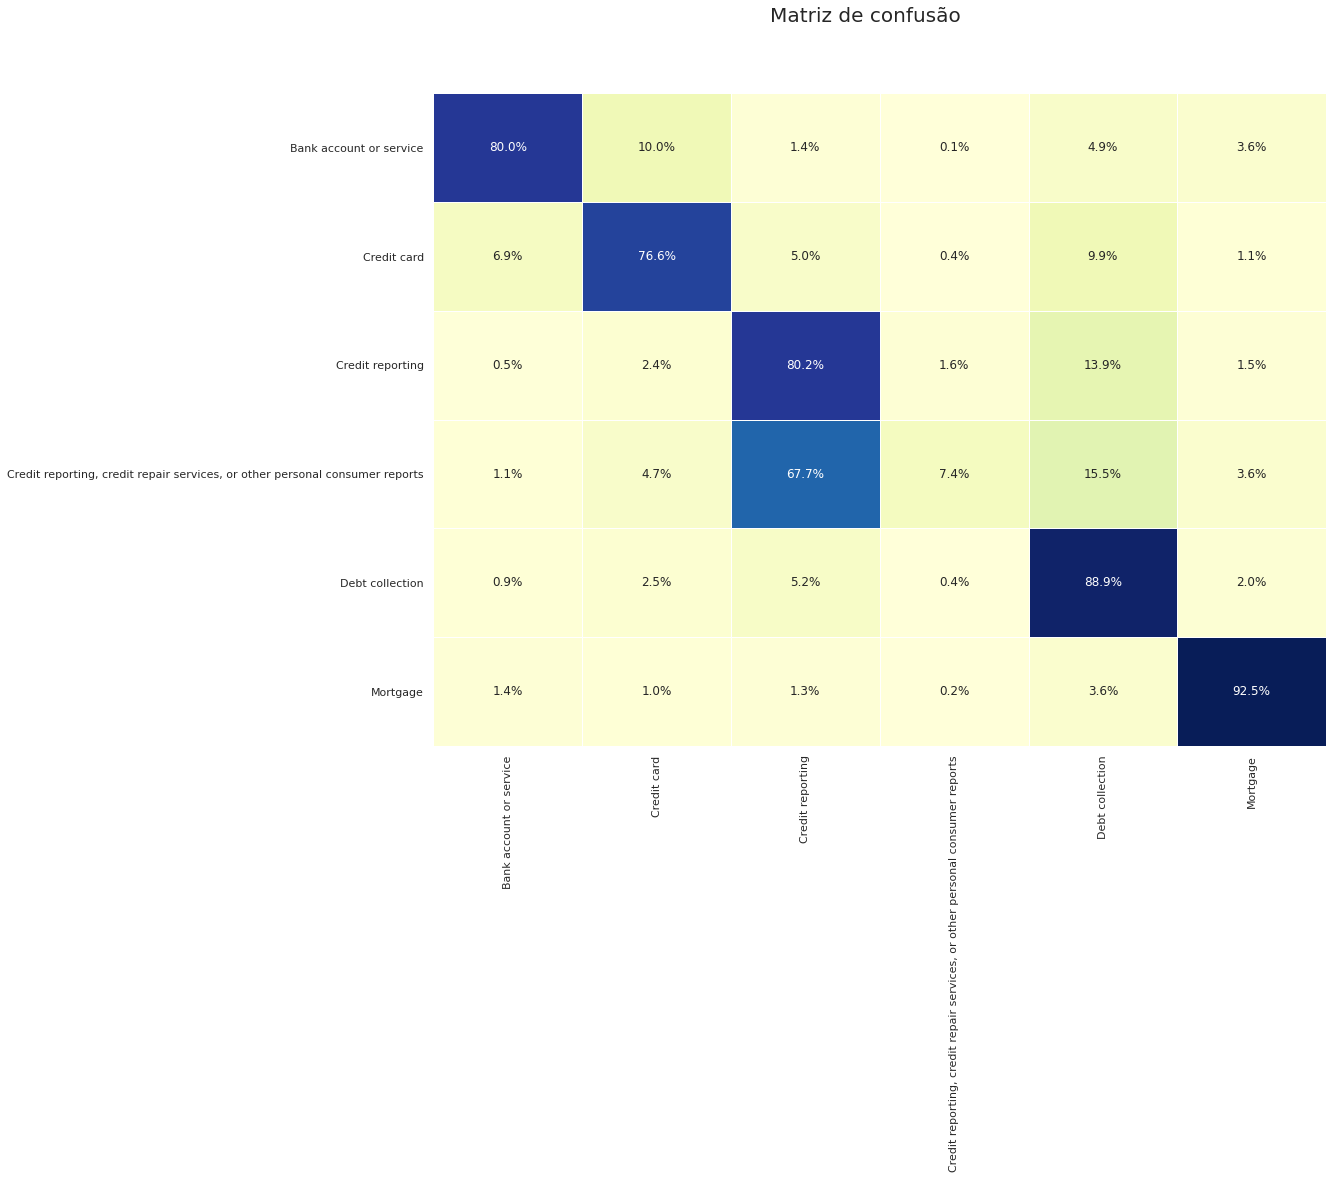

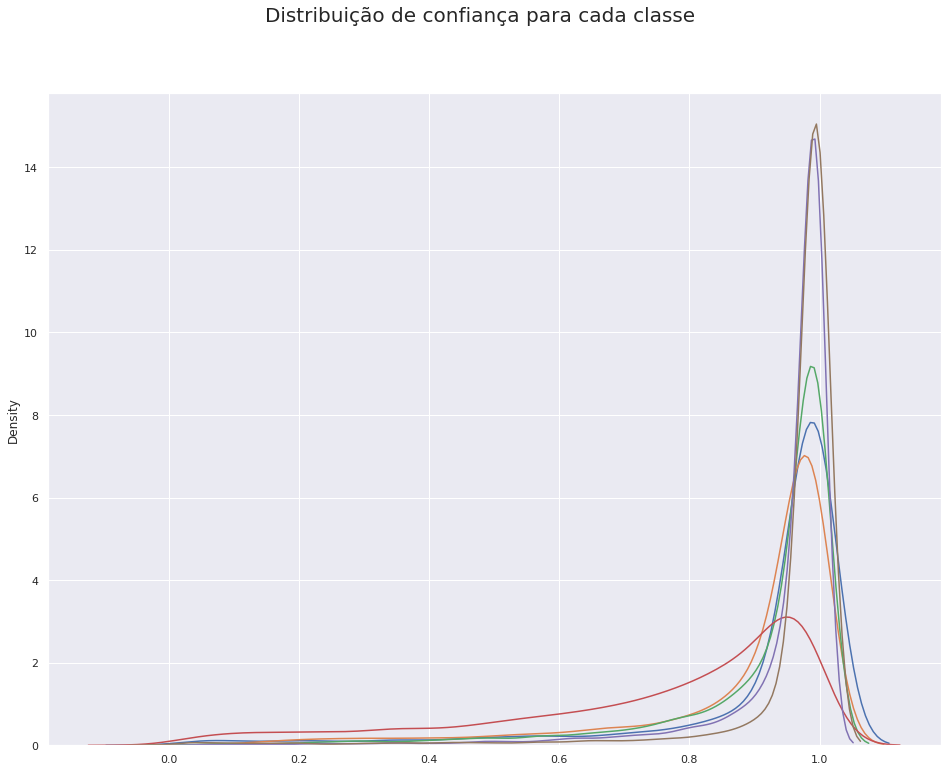

In [58]:
evaluate(ye_test, predicted_classes, probs, labels=label_enc.classes_)

**Atividade (1 pt):** treine a nova rede.

**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.